In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
# Data Transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine(degrees=(-7.0, 7.0), translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       #transforms.RandomAdjustSharpness(1.1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

In [5]:
torch.cuda.is_available()

True

torch.Size([64, 1, 28, 28])
torch.Size([64])


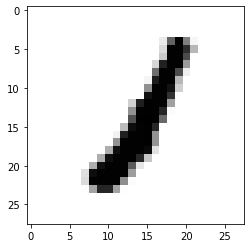

In [6]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

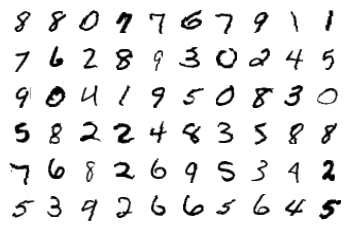

In [7]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [8]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


Loss=0.24914208054542542 Batch_id=937 Accuracy=93.78: 100%|██████████| 938/938 [00:10<00:00, 88.39it/s] 



Test set: Average loss: 0.0621, Accuracy: 9799/10000 (97.99%)

EPOCH: 1


Loss=0.011888708919286728 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:10<00:00, 91.20it/s]



Test set: Average loss: 0.0303, Accuracy: 9910/10000 (99.10%)

EPOCH: 2


Loss=0.02023753523826599 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:10<00:00, 91.58it/s]



Test set: Average loss: 0.0275, Accuracy: 9914/10000 (99.14%)

EPOCH: 3


Loss=0.03516384959220886 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:10<00:00, 91.12it/s] 



Test set: Average loss: 0.0291, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.15804673731327057 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:10<00:00, 90.60it/s]



Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.011268964037299156 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:10<00:00, 91.30it/s]



Test set: Average loss: 0.0311, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.04464658349752426 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:10<00:00, 90.32it/s]



Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.003474261611700058 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:10<00:00, 89.49it/s]



Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.05465521290898323 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:10<00:00, 91.37it/s] 



Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.008698537945747375 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:10<00:00, 90.82it/s]



Test set: Average loss: 0.0220, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.11097065359354019 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:10<00:00, 91.47it/s] 



Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.0030628745444118977 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:10<00:00, 91.32it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.02697267197072506 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:10<00:00, 91.23it/s] 



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.0026952442713081837 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:10<00:00, 90.14it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.042014025151729584 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:10<00:00, 89.41it/s] 



Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

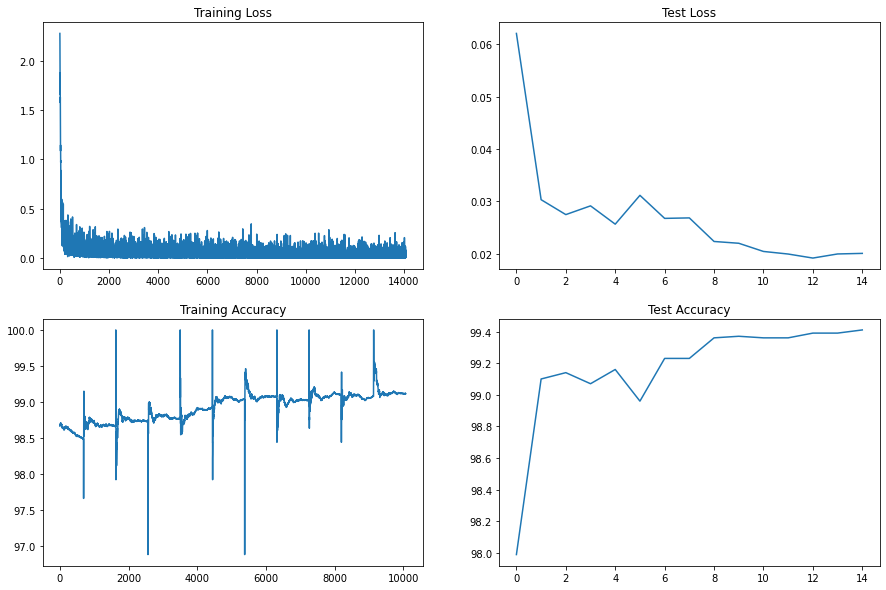

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")